May: **Research Questions 1.B.2** (Ideal and Real)

# Provided with upwelling-favourable wind forcing at the surface, what are the circulation patterns during an upwelling event in Mackenzie Canyon?

Circulation outside the canyon:

What are the horizontal velocities offshore, far away from the canyon?

In [13]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook
import circulation_plots

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [14]:
import importlib
importlib.reload(quicklook)

<module 'quicklook' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/quicklook.py'>

In [15]:
def get_uv_at_cross(dirname, fname, meshmaskname, x_ind):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    
    y = slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x_ind]
        vomecrty0 = dsV.variables['vomecrty'][:,:,y,x_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]
        depthv = dsV.variables['depthv'][:]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x_ind]
        vmask0 = dsM.variables['vmask'][0,:,y,x_ind]
        e1u = dsM.variables['e1u'][0, y, x_ind]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, vomecrty, umask[0, ...], vmask[0, ...], e1u, depthu, depthv, sozotaux

In [25]:
def plot_domain_cross_section(vozocrtxA, vomecrtyA, 
                               vozocrtxB, vomecrtyB,
                               vozocrtxC, vomecrtyC,
                               vozocrtxD, vomecrtyD,
                               depthu, x_inds, vm, levels, kind, case, flag):
    
    days = 6
    extra_rows=3
    cols = 4
    fig, axes = plt.subplots(days+extra_rows, cols, figsize=(20, 30), 
                             gridspec_kw={"height_ratios":[1.5,0.5,0.05,1,1,1,1,1,1]},sharey=True)
    for ax in axes[0, :]:
        ax.remove()
    for ax in axes[1, :]:
        ax.remove()
        
    cmap = cmo.cm.delta_r
    cmap.set_bad('silver')
    vmin, vmax = -1*vm, vm
    
    
    # --------------------------------------------------------------
    
    
    for x_ind, n in zip(x_inds, np.arange(axes.shape[1])):
        ax = axes[2, n]
        ax.axis("off")
        ax.set_title('x ind = '+str(x_ind), fontsize=30)
        #fig.colorbar(p, ax=ax, fraction=1.5, orientation='horizontal')
    
        
    # --------------------------------------------------------------
    
    
    if flag == 'U':
        vels = [vozocrtxA, vozocrtxB, vozocrtxC, vozocrtxD]
    elif flag == 'V':
        vels = [vomecrtyA, vomecrtyB, vomecrtyC, vomecrtyD]
        
    for x_ind, vel, n in zip(x_inds, vels, np.arange(axes.shape[1])):
        for d, m in zip(np.arange(days), np.arange(extra_rows, axes.shape[0])):
            vel_daily = quicklook.get_1day_avg(vel, d, d+1) 
            ys = np.arange(vel_daily.shape[-1])
            ax = axes[m, n]
            p = ax.pcolormesh(ys, depthu, vel_daily, cmap=cmap, vmin=vmin, vmax=vmax)
            cs = ax.contour(ys, depthu, vel_daily, levels = levels, alpha=0.8, linewidths=1.5)
            ax.clabel(cs, inline=1, fontsize=10, fmt = '%.1f')
            for line in cs.collections:
                line.set_linestyle([(None, None)])
                line.set_color('r')
            ax.xaxis.set_ticks(np.arange(0, ys[-1], 15))
            ax.grid()
            ax.set_xlim([0, 200])
            ax.set_ylim([600, 0])
            ax.set_title('Day '+str(d+1), fontsize=20)
            
    
    # --------------------------------------------------------------
    
    
    fig.tight_layout(w_pad=0.3, h_pad=0.5)
    plt.subplots_adjust(top=0.94)
    fig.suptitle(kind+' - '+case+': Daily '+flag+' velocity average cross-sections', fontsize=30)
            
    return fig

In [26]:
def make_plots(dirname, fname, meshmaskname, kind, case, x_inds):

    vozocrtxA, vomecrtyA, umaskA, vmaskA, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, meshmaskname, x_inds[0])
    vozocrtxB, vomecrtyB, umaskB, vmaskC, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, meshmaskname, x_inds[1])
    vozocrtxC, vomecrtyC, umaskC, vmaskC, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, meshmaskname, x_inds[2])
    vozocrtxD, vomecrtyD, umaskD, vmaskD, e1u, depthu, depthv, sozotaux = get_uv_at_cross(dirname, fname, meshmaskname, x_inds[3])

    # ----------------------------------------------------------------------------------------------------

    flag = 'U'
    vm=0.5
    levels = [-0.2, 0]

    fig = plot_domain_cross_section(vozocrtxA, vomecrtyA, 
                                   vozocrtxB, vomecrtyB,
                                   vozocrtxC, vomecrtyC,
                                   vozocrtxD, vomecrtyD,
                                   depthu, x_inds, vm, levels, kind, case, flag)

    #fig.savefig('../writing_images/crosssections_mid_'+kind+'_'+case+'_'+flag+'_chd.png', dpi=100, bbox_inches='tight')
    #plt.close(fig) 
    #print('done')

    # ----------------------------------------------------------------------------------------------------

    flag = 'V'
    vm=0.5
    levels = [-0.2, 0]

    fig = plot_domain_cross_section(vozocrtxA, vomecrtyA, 
                                   vozocrtxB, vomecrtyB,
                                   vozocrtxC, vomecrtyC,
                                   vozocrtxD, vomecrtyD,
                                   depthu, x_inds, vm, levels, kind, case, flag)

    #fig.savefig('../writing_images/crosssections_mid_'+kind+'_'+case+'_'+flag+'_chd.png', dpi=100, bbox_inches='tight')
    #plt.close(fig) 
    #print('done')
    
    return

# Constants

In [27]:
fname = "MCKNZ_1h_20170101_201701*"
meshmaskname = 'mesh_mask.nc'

# Ideal

In [28]:
kind = 'ideal'
x_inds = [125, 130, 135, 140]

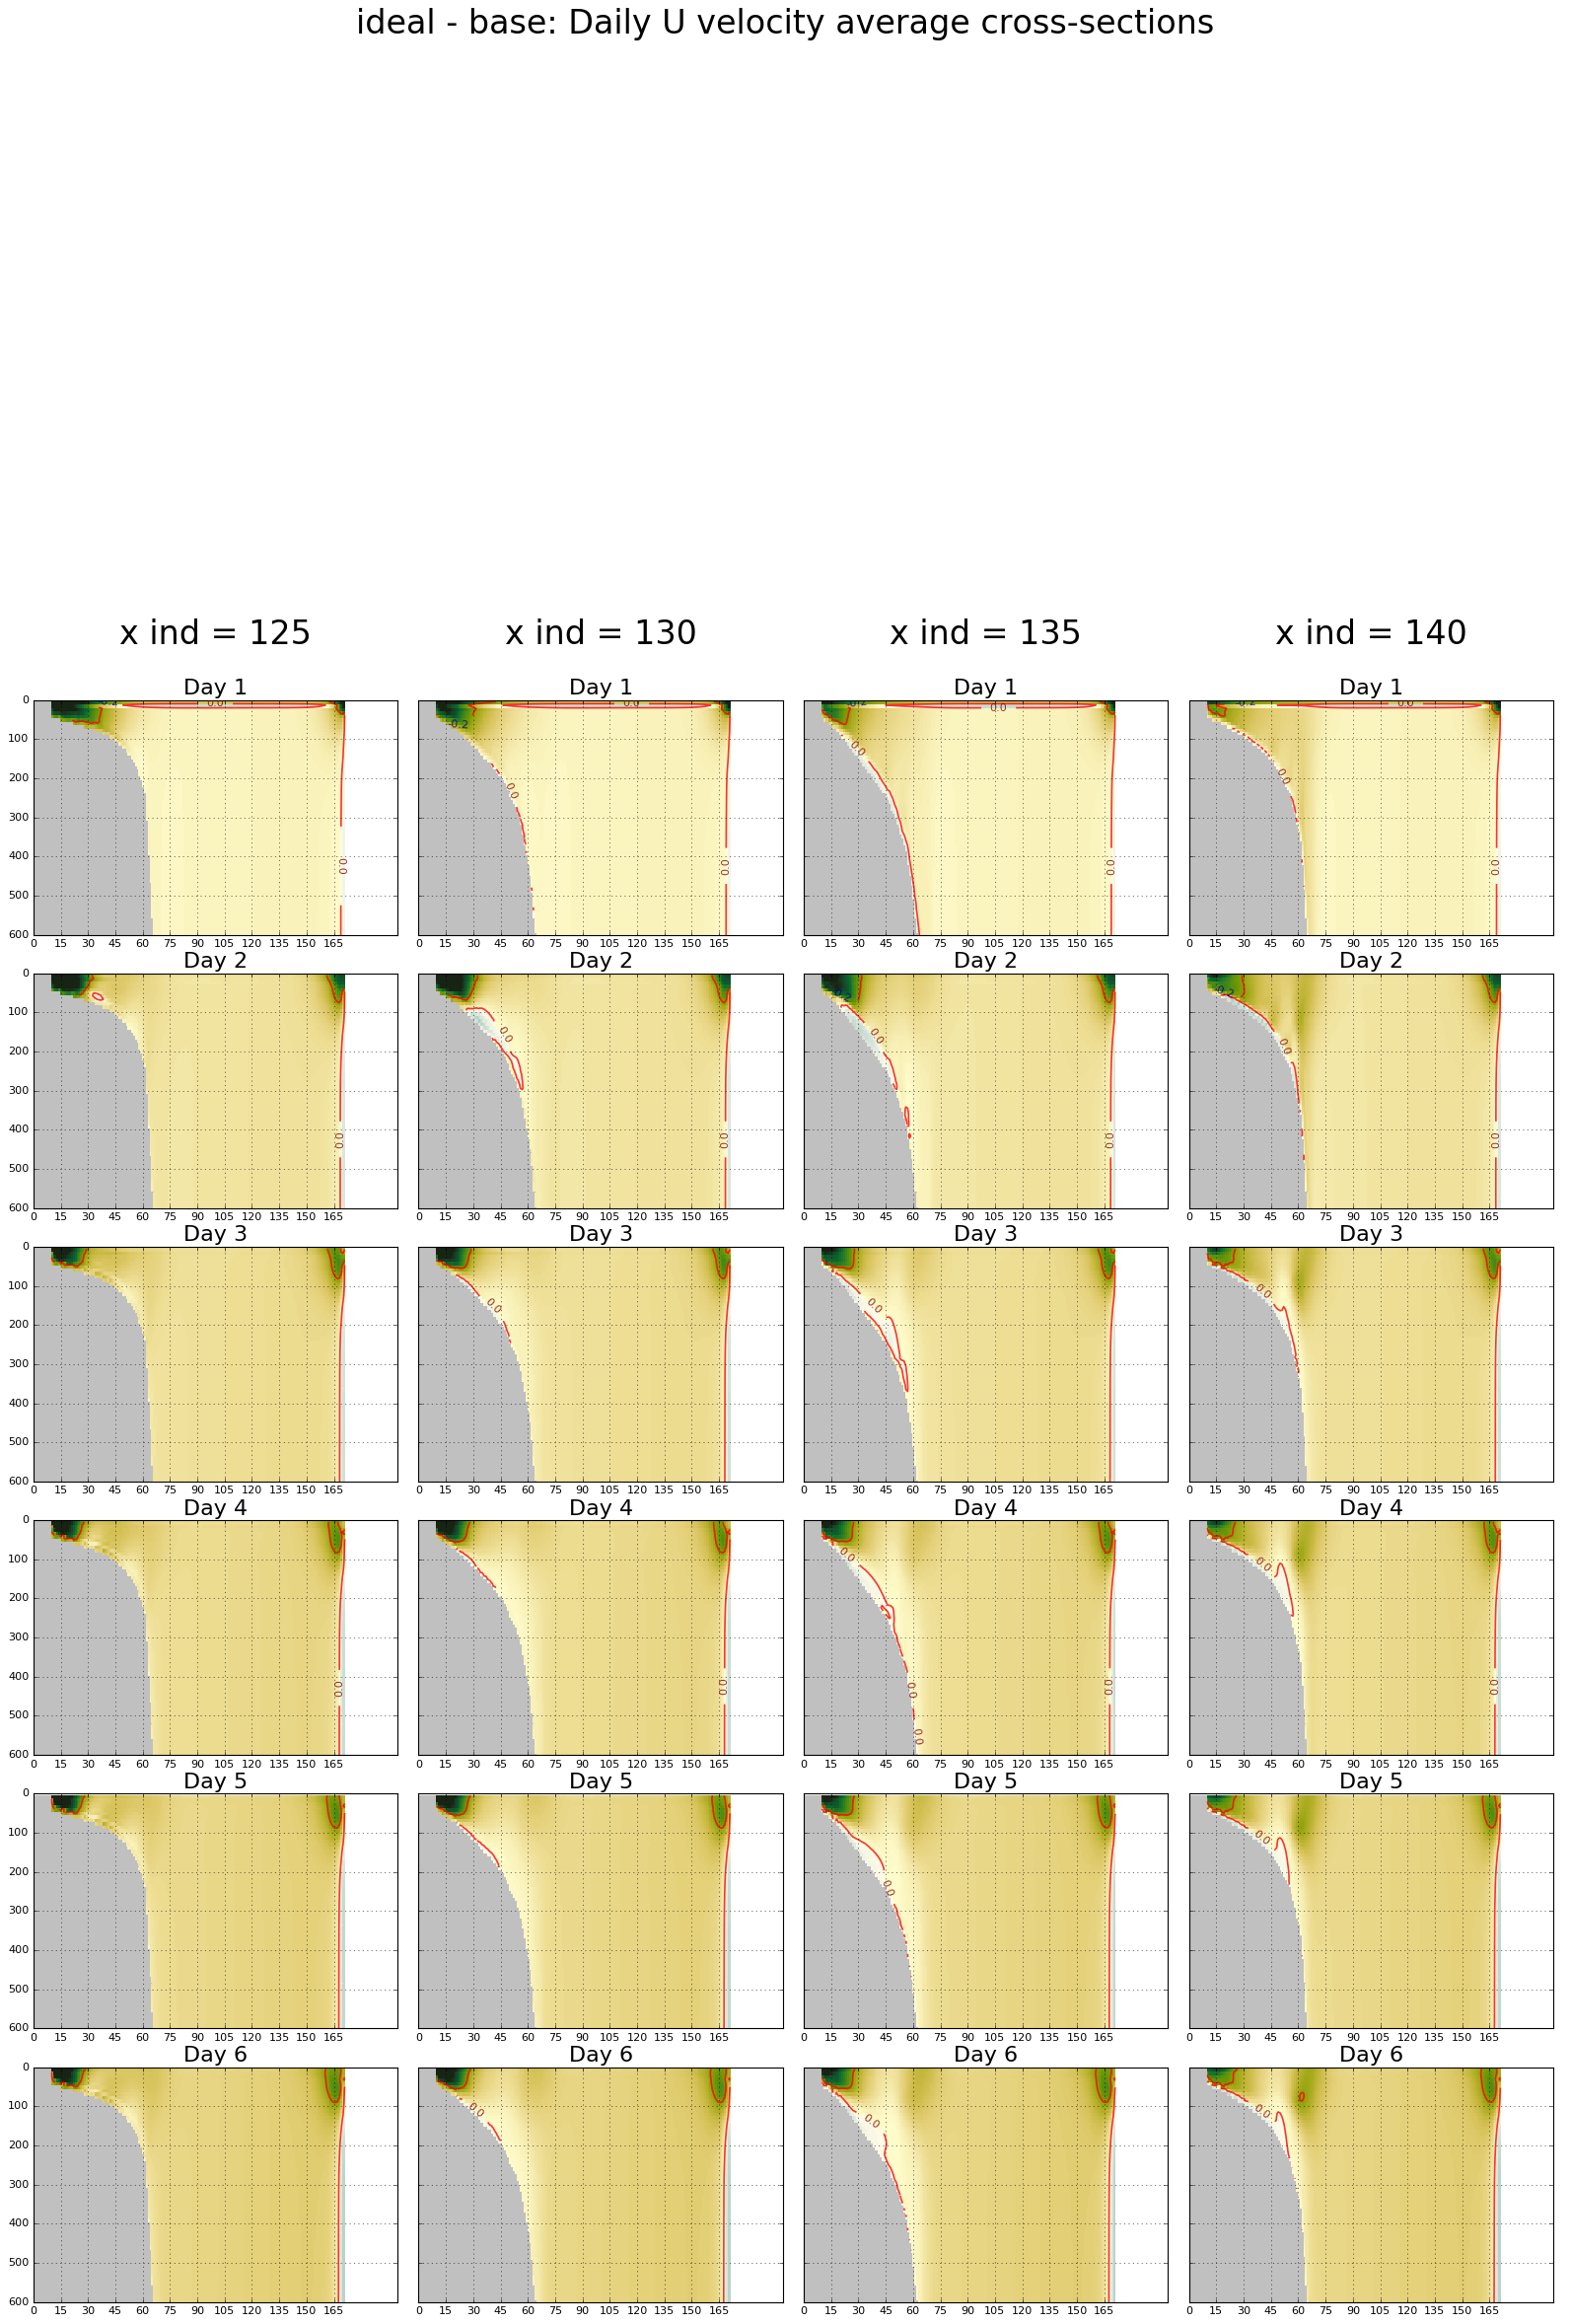

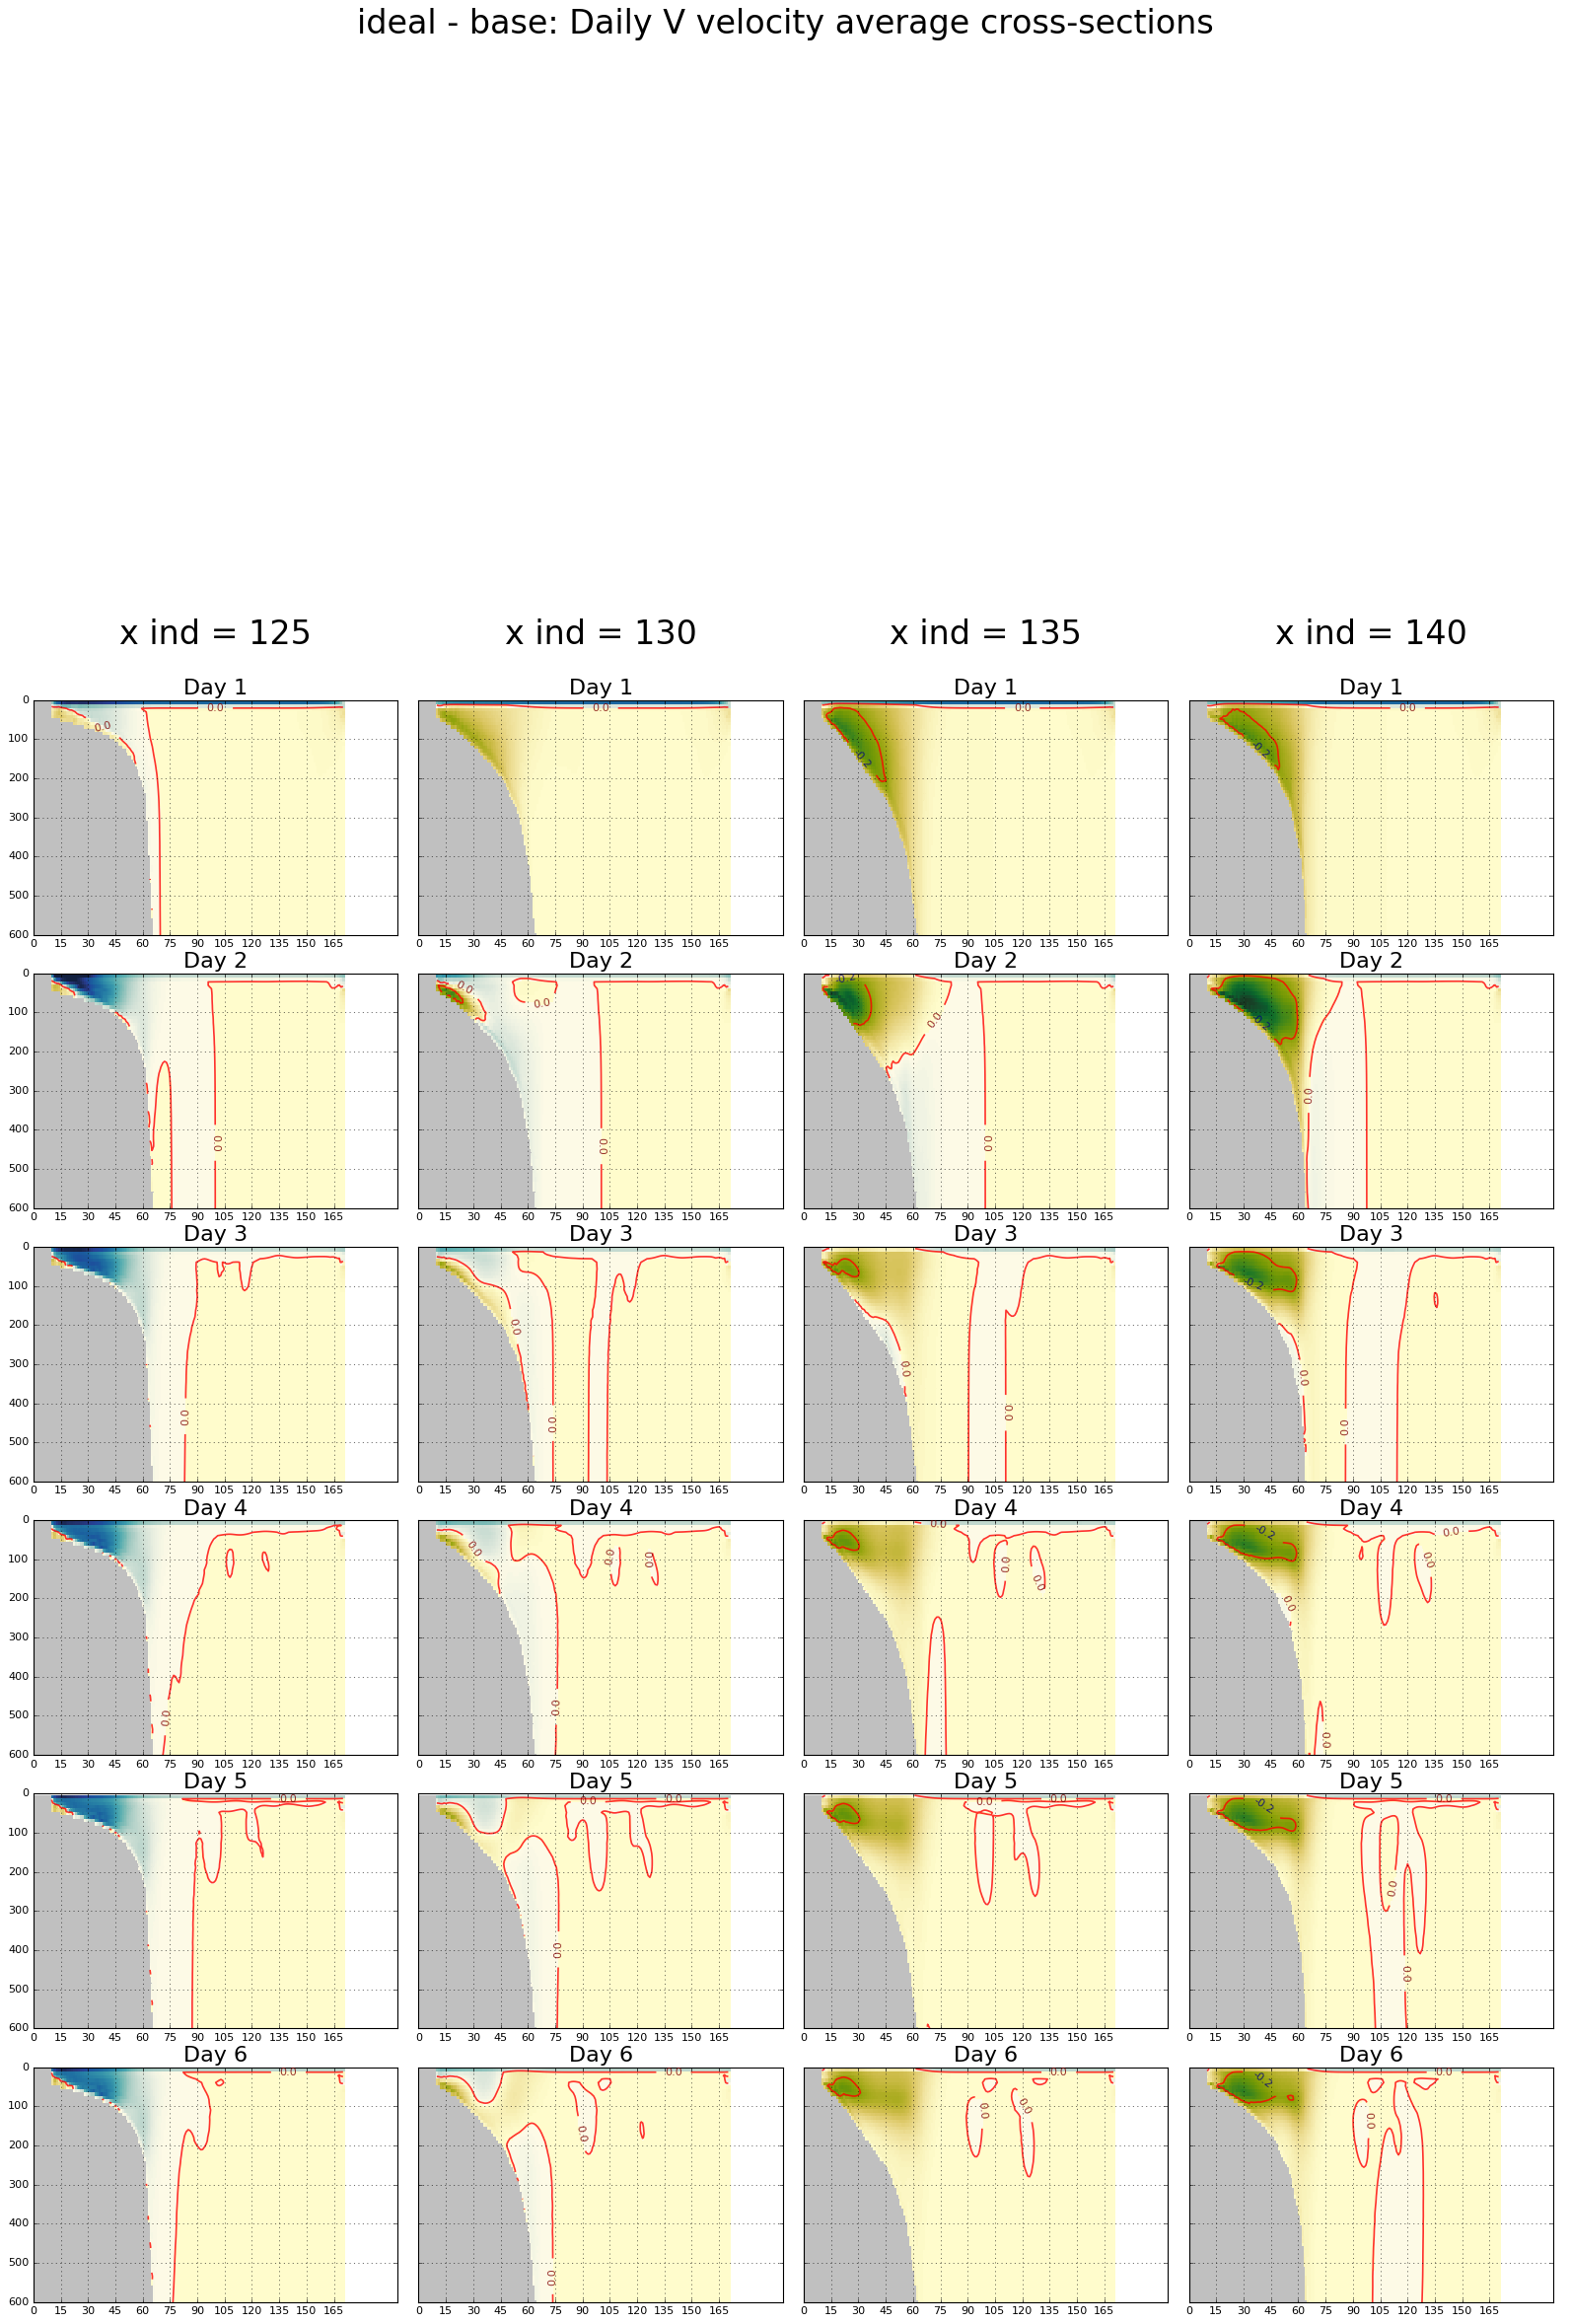

In [29]:
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)

In [ ]:
case = 'half'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)

In [ ]:
case = 'double'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)

# Real

In [ ]:
kind = 'real'
x_inds = [125, 130, 135, 140]

In [ ]:
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)

In [ ]:
case = 'half'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)

In [ ]:
case = 'double'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
make_plots(dirname, fname, meshmaskname, kind, case, x_inds)